In [1]:
import pandas as pd
import holidays
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from lightgbm import LGBMRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon

from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries

from skforecast.preprocessing import reshape_series_long_to_dict

from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries

from sklearn.metrics import mean_absolute_error

In [2]:
def date_range_uteis(inicio, fim):
    inicio = pd.to_datetime(inicio).date()
    fim    = pd.to_datetime(fim).date()
    anos = range(inicio.year, fim.year + 1)

    br = holidays.Brazil(years=anos)
    feriados = pd.to_datetime(list(br.keys()))

    cbd = pd.offsets.CustomBusinessDay(holidays=feriados)  # só seg-sex, exclui feriados
    return pd.date_range(inicio, fim, freq=cbd)


In [3]:
datas = date_range_uteis('2022-01-03', '2025-03-10')
entradas = np.sin(2*np.pi*np.arange(len(datas))/21) + 1 + 0.5*np.random.random(len(datas))
saidas = np.sin(2*np.pi*np.arange(len(datas))/21 + np.pi) + 1 + 0.5*np.random.random(len(datas))
subpolos = ['1.1', '2.1']

In [4]:
df1 = pd.DataFrame({'subpolo': len(datas)*['1.1'], 'entrada': entradas, 'saida': saidas, 'data': datas})
df2 = pd.DataFrame({'subpolo': len(datas)*['2.1'], 'entrada': 2*entradas, 'saida': 2*saidas, 'data': datas})
df = pd.concat([df1, df2]).set_index(['subpolo', 'data'])

In [5]:
# datas_test = df.index.get_level_values('data').unique()
br = holidays.Brazil(years=df.index.get_level_values('data').year.unique())
feriados = pd.to_datetime(list(br.keys()))
cbd = pd.offsets.CustomBusinessDay(holidays=feriados)
# datas = pd.date_range(df.index.get_level_values('data').min(), df.index.get_level_values('data').max(), freq=cbd)

In [6]:
df_dev = df[df.index.get_level_values('data').year < 2025][['entrada']]
df_dev = (
    df_dev.groupby(level=0, group_keys=True)
    .apply(lambda g: g.droplevel(0).asfreq(cbd))
)

df_test  = df[df.index.get_level_values('data').year >= 2025][['entrada']]
df_test = (
    df_test.groupby(level=0, group_keys=True)
    .apply(lambda g: g.droplevel(0).asfreq(cbd))
)

In [7]:
exog_dev = pd.DataFrame(index=df_dev.index)
datas_dev = df_dev.index.get_level_values('data')
exog_dev['dia'] = datas_dev.day
exog_dev['mes'] = datas_dev.month
exog_dev['dia_semana'] = datas_dev.weekday

exog_test = pd.DataFrame(index=df_test.index)
datas_test = df_test.index.get_level_values('data')
exog_test['dia'] = datas_test.day
exog_test['mes'] = datas_test.month
exog_test['dia_semana'] = datas_test.weekday

In [8]:
modelo = ForecasterRecursiveMultiSeries(
    regressor = LGBMRegressor(verbose=-1),
    lags      = 8,
    encoding  = 'ordinal_category'
)

In [15]:
cv = TimeSeriesFold(
    steps=22,
    window_size=8,
    initial_train_size='2024-10-10',
    refit=True,
    allow_incomplete_fold=False,
    gap=0
)

cv.split(df_dev.loc['1.1'])

Information of folds
--------------------
Number of observations used for initial training: 707
Number of observations used for backtesting: 55
    Number of folds: 2
    Number skipped folds: 0 
    Number of steps per fold: 22
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    The last 1 fold(s) have been excluded because they were incomplete.

Fold: 0
    Training:   2022-01-03 00:00:00 -- 2024-10-10 00:00:00  (n=707)
    Validation: 2024-10-11 00:00:00 -- 2024-11-11 00:00:00  (n=22)
Fold: 1
    Training:   2022-02-02 00:00:00 -- 2024-11-11 00:00:00  (n=707)
    Validation: 2024-11-12 00:00:00 -- 2024-12-13 00:00:00  (n=22)



[[0, [0, 707], [699, 707], [707, 729], [707, 729], True],
 [1, [22, 729], [721, 729], [729, 751], [729, 751], True]]

In [16]:
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster = modelo,
                                       series     = df_dev,
                                       exog       = exog_dev,
                                       levels     = None,
                                       cv         = cv,
                                       metric     = 'mean_absolute_error',
                                       suppress_warnings=True,
                                       show_progress=False
                                   )  

ValueError: `last_window` must have as many values as needed to generate the predictors. For this forecaster it is 8.

In [ ]:
import contextlib, io

def backtest(df, modelo, cv, col_target):

    # Considerando que a data está no level 1 do MultiIndex.
    df_datas = df.index.get_level_values(1)

    datas_unicas = df_datas.unique()
    datas_unicas.freq = cbd

    falso_stdout = io.StringIO()
    with contextlib.redirect_stdout(falso_stdout):
        split = cv.split(datas_unicas)

    metricas = []
    for i, (train_range, _, val_range, _, _) in enumerate(split):
        datas_train = datas[train_range[0] : train_range[1]]
        datas_val = datas[val_range[0] : val_range[1]]

        train_ini_dt, train_end_dt = datas_train[0], datas_train[-1]
        val_ini_dt, val_end_dt = datas_val[0], datas_val[-1]

        train = df[(df_datas >= train_ini_dt) & (df_datas <= train_end_dt)]
        val = df[(df_datas >= val_ini_dt) & (df_datas <= val_end_dt)]
        
        modelo.fit(train, suppress_warnings=True)
        preds = modelo.predict(cv.steps)

        levels = preds.level.unique()
        for level in levels:
            pred_level = preds.query(f"level == '{level}'")
            real_level = val.loc[level]
            df_merge = pd.merge(
                real_level, 
                pred_level, 
                right_index=True, 
                left_index=True,
                how='inner'
            )

            if len(pred_level) != len(df_merge) or len(real_level) != len(df_merge):
                raise Exception()

        metrica = mean_absolute_error(df_merge[col_target], df_merge['pred'])
        metricas.append(metrica)

    return metricas


In [11]:
def objective(trial, df, exog, modelo, cv, col_target):
    # 1. Sugerir hiperparâmetros
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500)
    }

    modelo.regressor.set_params(**params)

    # 2. Treinar e avaliar modelo (exemplo com XGBoost)
    metricas, _ = backtesting_forecaster_multiseries(
                                       forecaster = modelo,
                                       series     = df,
                                       exog       = exog_dev,
                                       levels     = None,
                                       cv         = cv,
                                       metric     = 'mean_absolute_error',
                                       suppress_warnings=True,
                                       show_progress=False
                                   )
    score = metricas.query("levels == 'average'").iloc[0, 1]

    # 3. Retornar o valor que queremos **minimizar ou maximizar**
    return score

In [12]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, df_dev, exog_dev, modelo, cv, 'entrada'), n_trials=50)

[I 2025-10-06 19:16:21,454] A new study created in memory with name: no-name-f66f858f-9840-4738-9128-148e71a2779b
[I 2025-10-06 19:16:22,524] Trial 0 finished with value: 1.0561754237450096 and parameters: {'learning_rate': 0.0005040029229697033, 'max_depth': 10, 'n_estimators': 144}. Best is trial 0 with value: 1.0561754237450096.
[I 2025-10-06 19:16:23,452] Trial 1 finished with value: 1.059746489834285 and parameters: {'learning_rate': 0.00016359976917392917, 'max_depth': 12, 'n_estimators': 123}. Best is trial 0 with value: 1.0561754237450096.
[I 2025-10-06 19:16:24,495] Trial 2 finished with value: 1.056388360169164 and parameters: {'learning_rate': 0.0005272609616336775, 'max_depth': 12, 'n_estimators': 189}. Best is trial 0 with value: 1.0561754237450096.
[I 2025-10-06 19:16:26,316] Trial 3 finished with value: 0.5643660028833335 and parameters: {'learning_rate': 0.0038173508007754925, 'max_depth': 12, 'n_estimators': 408}. Best is trial 3 with value: 0.5643660028833335.
[I 2025

In [53]:
passos = 22
modelo.regressor.set_params(**study.best_params)
modelo.fit(df_dev, exog=exog_dev, suppress_warnings=True)
preds = modelo.predict(passos, exog=exog_test)

In [54]:
modelo.get_feature_importances()

,feature,importance
0,lag_1,999
7,lag_8,827
1,lag_2,812
6,lag_7,763
3,lag_4,744
5,lag_6,730
4,lag_5,643
9,dia,543
2,lag_3,541
11,dia_semana,373


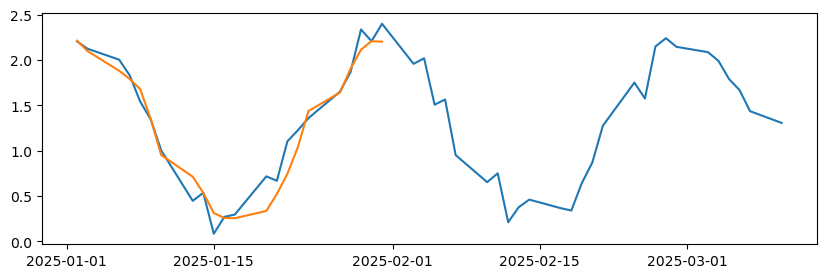

In [44]:
level = '1.1'
plt.figure(figsize=[10, 3])
plt.plot(df_test.loc[level, 'entrada'])
plt.plot(preds.query(f"level == '{level}'").pred)

In [45]:
mean_absolute_error(df_test.loc[level, 'entrada'].iloc[:passos], preds.query(f"level == '{level}'").pred)

0.11606587778355344